# House prices

Kairos (April 2018)

## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

# Feature Crosses
* Improve a linear regression model with the addition of additional synthetic features (this is a continuation of the previous exercise)
* Use an input function to convert pandas DataFrame objects to Tensors and invoke the input function in fit() and predict() operations
* Use the FTRL optimization algorithm for model training
* Create new synthetic features through one-hot encoding, binning, and feature crosses

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Load our data set
Next, we'll load our data set and show information about it.

In [2]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


In [3]:
# Create a synthetic feature.
# Create a new category for total habitable surface
housing_dataframe["habitableSF"] = housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"] + housing_dataframe["GrLivArea"]
#housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
housing_dataframe['SQMeter_price'] = 0  

In [4]:
housing_dataframe['SQMeter_price']

0       0
1       0
2       0
3       0
4       0
       ..
1446    0
1447    0
1448    0
1449    0
1450    0
Name: SQMeter_price, Length: 1451, dtype: int64

In [5]:
def preprocess_features(housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = housing_dataframe[
    ["MSZoning",
     "YearRemodAdd",
     "Utilities",
     "Neighborhood",
     "HouseStyle",
     "BedroomAbvGr",
     "OverallCond"]]
  processed_features = selected_features.copy()
  
 
  # Create a new synthetic feature
  processed_features['SQMeter_price'] = ( 
    housing_dataframe['SalePrice'] / 
    housing_dataframe['habitableSF'])

  return processed_features

def preprocess_targets(housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["SalePrice"] = (
    housing_dataframe["SalePrice"])
  return output_targets

## 3. Splitting

In [6]:
# Choose the first 1000 (out of 1451) examples for training.
training_examples = preprocess_features(housing_dataframe.head(1000))
training_targets = preprocess_targets(housing_dataframe.head(1000))

# Choose the last 500 (out of 1451) examples for validation.
validation_examples = preprocess_features(housing_dataframe.tail(500))
validation_targets = preprocess_targets(housing_dataframe.tail(500))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,SQMeter_price
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,0.4,1985.1,0.0,9.5,1.1,2.9,5.6,60.8
std,0.8,20.4,0.0,5.8,1.3,0.8,1.1,15.5
min,0.0,1950.0,0.0,0.0,0.0,0.0,1.0,15.2
25%,0.0,1967.0,0.0,5.0,0.0,2.0,5.0,50.7
50%,0.0,1994.0,0.0,10.0,1.0,3.0,5.0,60.2
75%,0.0,2004.0,0.0,13.0,1.0,3.0,6.0,69.3
max,4.0,2010.0,1.0,24.0,7.0,8.0,9.0,138.1


Validation examples summary:


,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,SQMeter_price
count,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,0.3,1983.8,0.0,9.3,1.2,2.9,5.6,59.3
std,0.8,21.2,0.0,6.0,1.3,0.8,1.1,15.7
min,0.0,1950.0,0.0,0.0,0.0,0.0,3.0,14.2
25%,0.0,1964.8,0.0,5.0,0.0,2.0,5.0,49.0
50%,0.0,1992.0,0.0,9.0,1.0,3.0,5.0,59.2
75%,0.0,2004.0,0.0,14.0,1.0,3.0,6.0,68.9
max,4.0,2010.0,0.0,24.0,7.0,6.0,9.0,118.8


Training targets summary:


,SalePrice
count,1000.0
mean,181962.4
std,80430.9
min,34900.0
25%,130000.0
50%,162950.0
75%,215000.0
max,755000.0


Validation targets summary:


,SalePrice
count,500.0
mean,176991.2
std,76270.3
min,37900.0
25%,128975.0
50%,160000.0
75%,203000.0
max,745000.0


In [7]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## 6. FTRL Optimization Algorithm

High dimensional linear models benefit from using a variant of gradient-based optimization called FTRL. This algorithm has the benefit of scaling the learning rate differently for different coefficients, which can be useful if some features rarely take non-zero values (it also is well suited to support L1 regularization). We can apply FTRL using the [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

In [9]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 196976.03
  period 01 : 196060.81
  period 02 : 195356.34
  period 03 : 194761.83
  period 04 : 194237.80
  period 05 : 193763.84
  period 06 : 193328.10
  period 07 : 192923.26
  period 08 : 192542.71
  period 09 : 192182.45
Model training finished.


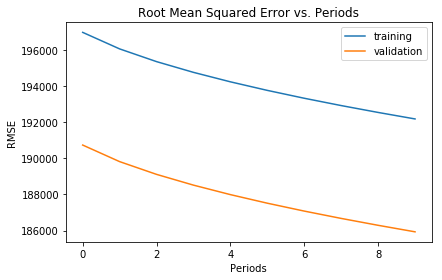

In [10]:
_ = train_model(
    learning_rate=0.1,
    steps=350,
    batch_size=5,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## 7. One-Hot Encoding for Discrete Features
Discrete (i.e. strings, enumerations, integers) features are usually converted into families of binary features before training a logistic regression model.

For example, suppose we created a synthetic feature that can take any of the values 0, 1 or 2, and that we have a few training points:

#	feature_value
0	2
1	0
2	1
For each possible categorical value, we make a new binary feature of real values that can take one of just two possible values: 1.0 if the example has that value, and 0.0 if not. In the example above, the categorical feature would be converted into three features, and the training points now look like:

#	feature_value_0	feature_value_1	feature_value_2
0	0.0	            0.0	            1.0
1	1.0	            0.0	            0.0
2	0.0	            1.0	            0.0

## Bucketized (Binned) Features
Bucketization is also known as binning.

We can bucketize SQMeter_price into the following 3 buckets (for instance):

bucket_0 (< 50): corresponding to little SQMeter_price 
bucket_1 (50 - 250): corresponding to mid SQMeter_price
bucket_2 (> 250): corresponding to high SQMeter_price
Given the preceding bucket definitions, the following SQMeter_price vector:

[[40], [100], [300], [35]]
becomes the following bucketized feature vector:

[[1], [2], [0], [1]]
The feature values are now the bucket indices. Note that these indices are considered to be discrete features. Typically, these will be further converted in one-hot representations as above, but this is done transparently.

To define feature columns for bucketized features, instead of using numeric_column, we can use bucketized_column, which takes a numeric column as input and transforms it to a bucketized feature using the bucket boundaries specified in the boundardies argument. The following code defines bucketized feature columns for households and longitude; the get_quantile_based_boundaries function calculates boundaries based on quantiles, so that each bucket contains an equal number of elements.

In [11]:
# Let's fill SQMeter_price feature with values
housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
housing_dataframe["SQMeter_price"]

0      61.0
1      71.9
2      62.6
3      40.8
4      56.9
       ... 
1446   53.1
1447   50.7
1448   56.9
1449   65.9
1450   58.7
Name: SQMeter_price, Length: 1451, dtype: float64

In [12]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  q = [quantiles[q] for q in quantiles.keys()]
  sorted(q)
  return q

# Divide SQMeter_price into 7 buckets.
SQMeter_price = tf.feature_column.numeric_column("SQMeter_price")
bucketized_SQMeter_price = tf.feature_column.bucketized_column(
  SQMeter_price, boundaries=get_quantile_based_boundaries(
    housing_dataframe["SQMeter_price"], 7))

# Divide habitableSF into 7 buckets.
habitableSF = tf.feature_column.numeric_column("habitableSF")
bucketized_habitableSF = tf.feature_column.bucketized_column(
  habitableSF, boundaries=get_quantile_based_boundaries(
    housing_dataframe["habitableSF"], 7))


### Task 1: Train the Model on Bucketized Feature Columns
Bucketize all the real valued features in our example, train the model and see if the results improve.

In the preceding code block, two real valued columns (namely SQMeter_price and habitableSF) have been transformed into bucketized feature columns. Your task is to bucketize the rest of the columns, then run the code to train the model. There are various heuristics to find the range of the buckets. This exercise uses a quantile-based technique, which chooses the bucket boundaries in such a way that each bucket has the same number of examples.

In [13]:
x = boundaries=get_quantile_based_boundaries(training_examples["BedroomAbvGr"], 5)
print x

[2.0, 3.0, 3.0, 3.0]


In [37]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  MSZoning = tf.feature_column.numeric_column("MSZoning")
  YearRemodAdd = tf.feature_column.numeric_column("YearRemodAdd")
  Utilities = tf.feature_column.numeric_column("Utilities")
  Neighborhood = tf.feature_column.numeric_column("Neighborhood")
  HouseStyle = tf.feature_column.numeric_column("HouseStyle")
  BedroomAbvGr = tf.feature_column.numeric_column("BedroomAbvGr")
  
  # Divide MSZoning into 2 buckets.
  
  bucketized_MSZoning = tf.feature_column.bucketized_column(
    MSZoning, boundaries=get_quantile_based_boundaries(
      training_examples["MSZoning"], 2))

  # Divide YearRemodAdd into 10 buckets.
  bucketized_YearRemodAdd = tf.feature_column.bucketized_column(
    YearRemodAdd, boundaries=get_quantile_based_boundaries(
      training_examples["YearRemodAdd"], 10))

  # Divide Utilities into 2 buckets.
  bucketized_Utilities = tf.feature_column.bucketized_column(
    Utilities, boundaries=get_quantile_based_boundaries(
      training_examples["Utilities"], 2))
  
  # Divide Neighborhood into 10 buckets.
  bucketized_Neighborhood = tf.feature_column.bucketized_column(
    Neighborhood, boundaries=get_quantile_based_boundaries(
      training_examples["Neighborhood"], 10))

  # Divide HouseStyle into 2 buckets.
  bucketized_HouseStyle = tf.feature_column.bucketized_column(
    HouseStyle, boundaries=get_quantile_based_boundaries(
      training_examples["HouseStyle"], 2))
  
  # Divide BedroomAbvGr into 2 buckets.
  bucketized_BedroomAbvGr = tf.feature_column.bucketized_column(
    BedroomAbvGr, boundaries=get_quantile_based_boundaries(
      training_examples["BedroomAbvGr"], 2))
  
  
  
  feature_columns = set([
    bucketized_MSZoning,
    bucketized_YearRemodAdd,
    bucketized_Utilities,
    bucketized_Neighborhood,
    bucketized_BedroomAbvGr])
  
  return feature_columns


Training model...
RMSE (on training data):
  period 00 : 197804.88
  period 01 : 197324.19
  period 02 : 196955.81
  period 03 : 196645.10
  period 04 : 196371.70
  period 05 : 196124.47
  period 06 : 195896.86
  period 07 : 195685.27
  period 08 : 195486.67
  period 09 : 195299.04
Model training finished.


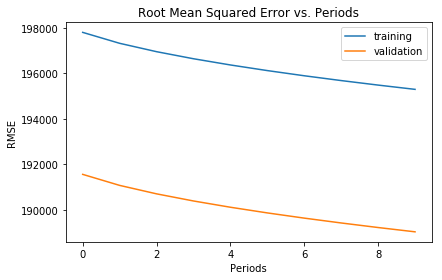

In [38]:
_ = train_model(
    learning_rate=4.5,
    steps=10000,
    batch_size=1,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Task 2: Train the Model Using Feature Crosses
Add a feature cross of longitude and latitude to your model, train it, and determine whether the results improve.

Refer to the TensorFlow API docs for crossed_column() to build the feature column for your cross. Use a hash_bucket_size of 1000.

In [43]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  MSZoning = tf.feature_column.numeric_column("MSZoning")
  YearRemodAdd = tf.feature_column.numeric_column("YearRemodAdd")
  Utilities = tf.feature_column.numeric_column("Utilities")
  Neighborhood = tf.feature_column.numeric_column("Neighborhood")
  HouseStyle = tf.feature_column.numeric_column("HouseStyle")
  BedroomAbvGr = tf.feature_column.numeric_column("BedroomAbvGr")
  
  # Divide MSZoning into 2 buckets.
  
  bucketized_MSZoning = tf.feature_column.bucketized_column(
    MSZoning, boundaries=get_quantile_based_boundaries(
      training_examples["MSZoning"], 2))

  # Divide YearRemodAdd into 10 buckets.
  bucketized_YearRemodAdd = tf.feature_column.bucketized_column(
    YearRemodAdd, boundaries=get_quantile_based_boundaries(
      training_examples["YearRemodAdd"], 10))

  # Divide Utilities into 2 buckets.
  bucketized_Utilities = tf.feature_column.bucketized_column(
    Utilities, boundaries=get_quantile_based_boundaries(
      training_examples["Utilities"], 2))
  
  # Divide Neighborhood into 10 buckets.
  bucketized_Neighborhood = tf.feature_column.bucketized_column(
    Neighborhood, boundaries=get_quantile_based_boundaries(
      training_examples["Neighborhood"], 10))

  # Divide HouseStyle into 2 buckets.
  bucketized_HouseStyle = tf.feature_column.bucketized_column(
    HouseStyle, boundaries=get_quantile_based_boundaries(
      training_examples["HouseStyle"], 2))
  
  # Divide BedroomAbvGr into 2 buckets.
  bucketized_BedroomAbvGr = tf.feature_column.bucketized_column(
    BedroomAbvGr, boundaries=get_quantile_based_boundaries(
      training_examples["BedroomAbvGr"], 2))
  
  # Make a feature column for the YearRemodAdd_x_Neighborhood feature cross
  YearRemodAdd_x_Neighborhood = tf.feature_column.crossed_column(
  set([bucketized_Neighborhood, bucketized_YearRemodAdd]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_MSZoning,
    bucketized_YearRemodAdd,
    bucketized_Utilities,
    bucketized_Neighborhood,
    bucketized_BedroomAbvGr,
    YearRemodAdd_x_Neighborhood])
  
  return feature_columns


Training model...
RMSE (on training data):
  period 00 : 197769.40
  period 01 : 197272.21
  period 02 : 196890.81
  period 03 : 196570.15
  period 04 : 196287.66
  period 05 : 196032.13
  period 06 : 195797.41
  period 07 : 195578.08
  period 08 : 195372.84
  period 09 : 195178.16
Model training finished.


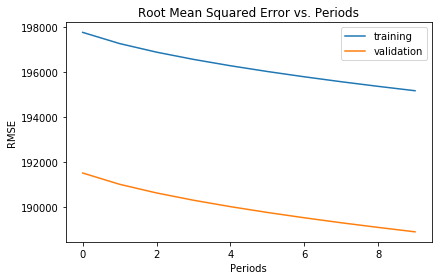

In [44]:
_ = train_model(
    learning_rate=4.5,
    steps=10000,
    batch_size=1,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)